In [31]:
## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3

In [32]:
#Acesso às pastas contendo os arquivos de áudio de cada ator

dir_list = os.listdir('Documents/Faculdade/TCC/audios/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [33]:
# Criação do data frame contendo as informações dos arquivos de áudio
initial_df = pd.DataFrame(columns=['path', 'emotion','intensity',
                                   'statement','repeat', 'actor', 'gender'])
count = 0
for i in dir_list:
    file_list = os.listdir('Documents/Faculdade/TCC/audios/' + i)
    for f in file_list:
        file_name = f.split('.')[0].split('-')
        path = 'Documents/Faculdade/TCC/audios/' + i + '/' + f
        actor = int(file_name[-1])
        emotion = int(file_name[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if file_name[3] == '01':
            intensity = 'normal'
        else:
            intensity = 'strong'
        
        if file_name[4] == '01':
            statement = 'statement 1'
        else:
            statement = 'statement 2'
        
        if file_name[5] == '01':
            repeat = 1
        else:
            repeat = 2
            
        initial_df.loc[count] = [path, emotion, intensity, statement, repeat, actor, gender]
        count += 1

In [34]:
print (len(initial_df))
initial_df.head()

1440


,path,emotion,intensity,statement,repeat,actor,gender
0,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,8,strong,statement 2,1,1,male
1,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,8,normal,statement 1,1,1,male
2,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,5,normal,statement 2,1,1,male
3,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,6,normal,statement 2,2,1,male
4,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,6,strong,statement 1,2,1,male


In [35]:
filename = initial_df.path[1024]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

Documents/Faculdade/TCC/audios/Actor_18/03-01-01-01-01-02-18.wav


(22050, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [36]:
# Corte do áudio para retirar a parte silenciosa
trim, trim_rate = librosa.effects.trim(samples, top_db=30)
trim, trim_rate

(array([-1.9141038e-07, -4.1607140e-07,  2.0688096e-06, ...,
         5.6699279e-05,  2.1195672e-05,  3.1794041e-06], dtype=float32),
 array([20992, 58880]))

In [37]:
# Áudio original
ipd.Audio(samples, rate=sample_rate)

In [38]:
# Áudio após o corte
ipd.Audio(trim, rate=sample_rate)

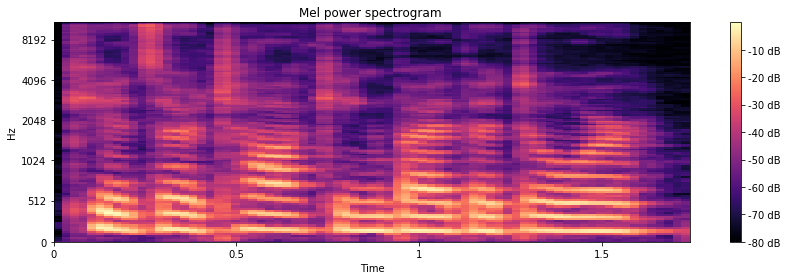

In [39]:
# Geração do espectrograma Mel Power

S = librosa.feature.melspectrogram(trim, sr=sample_rate, n_mels=128)

# Converte pra db
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

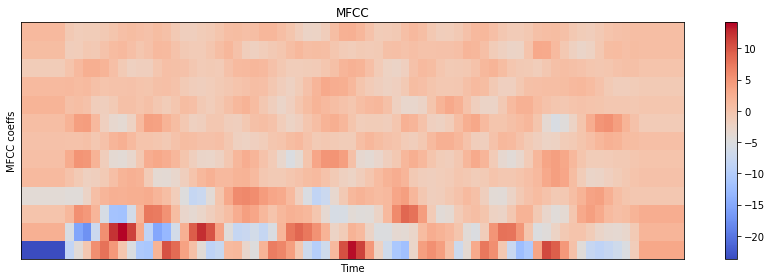

In [40]:
# Geração do MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [41]:
# Definindo um label para cada arquivo considerando a emoção

label_list = []
for i in range(len(initial_df)):
    if initial_df.emotion[i] == 1:
        lb = "neutral"
    elif initial_df.emotion[i] == 2:
        lb = "calm"
    elif initial_df.emotion[i] == 3:
        lb = "happy"
    elif initial_df.emotion[i] == 4:
        lb = "sad"
    elif initial_df.emotion[i] == 5:
        lb = "angry"
    elif initial_df.emotion[i] == 6:
        lb = "fearful"
    elif initial_df.emotion[i] == 7:
        lb = "disgust"
    elif initial_df.emotion[i] == 8:
        lb = "surprised"
         
    label_list.append(lb)
    
len(label_list)

1440

In [42]:
initial_df['label'] = label_list
initial_df.head()

,path,emotion,intensity,statement,repeat,actor,gender,label
0,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,8,strong,statement 2,1,1,male,surprised
1,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,8,normal,statement 1,1,1,male,surprised
2,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,5,normal,statement 2,1,1,male,angry
3,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,6,normal,statement 2,2,1,male,fearful
4,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,6,strong,statement 1,2,1,male,fearful


In [43]:
#Criação de um data frame separado apenas para uma frase
df_female = initial_df[initial_df.gender!= "male"].reset_index(drop=True)
df_female = df_female[df_female.statement != "statement 2"].reset_index(drop=True)
df_female.head()

,path,emotion,intensity,statement,repeat,actor,gender,label
0,Documents/Faculdade/TCC/audios/Actor_02/03-01-...,5,strong,statement 1,1,2,female,angry
1,Documents/Faculdade/TCC/audios/Actor_02/03-01-...,6,strong,statement 1,2,2,female,fearful
2,Documents/Faculdade/TCC/audios/Actor_02/03-01-...,4,normal,statement 1,2,2,female,sad
3,Documents/Faculdade/TCC/audios/Actor_02/03-01-...,7,normal,statement 1,1,2,female,disgust
4,Documents/Faculdade/TCC/audios/Actor_02/03-01-...,8,normal,statement 1,1,2,female,surprised


In [44]:
print(len(df_female))

360


In [45]:
# Geração de um dataframe contendo apenas os valores de feature do mfccs feminino
df_feature_fem = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(df_female))):
    X, sample_rate = librosa.load(df_female.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    df_feature_fem.loc[i] = [feature]

100%|██████████| 360/360 [00:18<00:00, 19.12it/s]


In [46]:
df_feature_fem.head()

,feature
0,"[-46.882404, -46.882404, -46.882404, -46.88240..."
1,"[-50.25022, -50.25022, -50.25022, -50.255898, ..."
2,"[-64.79879, -64.79879, -64.79879, -64.79879, -..."
3,"[-63.462185, -63.462185, -63.462185, -63.46218..."
4,"[-58.014015, -58.014015, -58.014015, -58.01401..."


In [47]:
#Conversão dos valores de feature obtidos em uma lista de features
female_feature = pd.DataFrame(df_feature_fem['feature'].values.tolist())
female_labels = df_female.label

In [48]:
female_feature.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,...,-39.710136,-41.268486,-42.326485,-41.530411,-40.616009,-42.234097,-44.707256,-42.755268,-43.395042,-43.297340
1,-50.250221,-50.250221,-50.250221,-50.255898,-50.314941,-50.416325,-50.497036,-50.365112,-49.938881,-48.832802,...,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221
2,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,...,-59.002506,-62.461777,-60.261032,-61.106796,-62.670967,-63.305935,-64.351013,-63.747128,-62.303509,-59.542152
3,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,...,-58.973660,-59.601780,-59.414841,-59.366642,-61.903957,-61.388008,-59.283669,-57.126545,-58.169682,-61.271927
4,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,...,-54.171513,-53.496052,-52.901150,-53.750023,-54.096409,-57.197750,-55.990200,-52.919193,-54.385361,-56.049984


In [49]:
fem_feature_lbl = pd.concat([female_feature,female_labels], axis=1)

In [50]:
fem_feature_labels = fem_feature_lbl.rename(index=str, columns={"0": "label"})
len(fem_feature_labels)

360

In [51]:
fem_feature_labels.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,...,-41.268486,-42.326485,-41.530411,-40.616009,-42.234097,-44.707256,-42.755268,-43.395042,-43.297340,angry
1,-50.250221,-50.250221,-50.250221,-50.255898,-50.314941,-50.416325,-50.497036,-50.365112,-49.938881,-48.832802,...,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,fearful
2,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,...,-62.461777,-60.261032,-61.106796,-62.670967,-63.305935,-64.351013,-63.747128,-62.303509,-59.542152,sad
3,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,...,-59.601780,-59.414841,-59.366642,-61.903957,-61.388008,-59.283669,-57.126545,-58.169682,-61.271927,disgust
4,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,...,-53.496052,-52.901150,-53.750023,-54.096409,-57.197750,-55.990200,-52.919193,-54.385361,-56.049984,surprised
5,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.049198,...,-56.414230,-57.529278,-58.395977,-57.555782,-55.938557,-57.477436,-58.245872,-57.615925,-58.954491,happy
6,-61.444542,-61.444542,-61.444542,-61.444542,-61.444542,-61.444542,-61.444542,-61.444542,-61.444542,-61.444542,...,-56.521294,-58.418499,-58.609535,-58.212059,-59.722317,-60.111309,-59.459187,-59.079613,-60.787094,calm
7,-49.195332,-49.195332,-49.195332,-49.195332,-49.195332,-49.195332,-49.195332,-49.195332,-49.195332,-49.195332,...,-49.195332,-49.195332,-49.195332,-49.195332,-49.195332,-49.195332,-49.195332,-49.195332,-49.195332,happy
8,-63.214199,-63.214199,-63.214199,-63.214199,-63.214199,-63.167271,-63.385483,-63.461838,-63.336159,-63.204266,...,-57.446770,-56.563107,-57.616249,-59.265163,-58.459743,-58.536587,-56.540466,-52.289421,-50.806602,neutral
9,-65.278046,-65.278046,-65.278046,-65.278046,-65.278046,-65.278046,-65.278046,-65.278046,-65.278046,-65.278046,...,-59.825798,-60.674294,-62.128029,-63.902176,-63.127159,-65.071747,-62.194946,-61.719948,-64.359726,calm


In [52]:
#Geração do gráfico de frequência da voz
def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

#Reduzir o barulho
def noise(data):
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

#Organizar as linhas do array de forma aleatória
def shift(data):
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)

#Esticar o som
def stretch(data, rate=0.8):
    data = librosa.effects.time_stretch(data, rate)
    return data

#Afinar o tom da voz
def pitch(data, sample_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data

#Mudar valores de forma aleatória
def dyn_change(data):
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)

#Alterar velocidade do tom
def speedNpitch(data):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [53]:
# Aplicação de um método de Augmentation

syn_data1f = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(df_female))):
    X, sample_rate = librosa.load(df_female.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if df_female.label[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1f.loc[i] = [feature, df_female.label[i]]

100%|██████████| 360/360 [00:21<00:00, 16.85it/s]


In [54]:
# Aplicação de outro método de Augmentation

syn_data2f = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(df_female))):
    X, sample_rate = librosa.load(df_female.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if df_female.label[i]:
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2f.loc[i] = [feature, df_female.label[i]]

100%|██████████| 360/360 [01:28<00:00,  4.09it/s]


In [55]:
len(syn_data1f), len(syn_data2f)

(360, 360)

In [56]:
syn_data1f = syn_data1f.reset_index(drop=True)
syn_data2f = syn_data2f.reset_index(drop=True)

In [57]:
featf = pd.DataFrame(syn_data1f['feature'].values.tolist())
labelsf = syn_data1f.label
syndf1_fem = pd.concat([featf,labelsf], axis=1)
syndf1_fem = syndf1_fem.rename(index=str, columns={"0": "label"})
syndf1_fem = syndf1_fem.fillna(0)
len(syndf1_fem)

360

In [58]:
syndf1_fem.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-46.882401,-46.882401,-46.882401,-46.882401,-46.882401,-46.882401,-46.882401,-46.882401,-46.882401,-46.882401,...,-41.378906,-42.388977,-41.307121,-40.409794,-41.865086,-44.383663,-42.854351,-43.518929,-43.052143,angry
1,-43.944702,-41.682167,-40.728256,-40.310829,-39.972122,-42.609749,-42.852573,-40.062508,-37.460457,-39.978535,...,-41.739418,-43.121906,-41.298302,-38.884842,-38.548862,-40.372524,-40.960728,-40.449287,-41.036900,fearful
2,-59.199913,-59.233341,-58.858624,-58.859047,-60.422459,-59.775105,-60.633457,-58.978821,-57.582294,-60.034958,...,-60.935032,-59.982204,-59.311852,-60.864666,-58.450333,-58.552170,-59.612045,-58.828491,-57.157673,sad
3,-54.812614,-53.606323,-57.560097,-58.579910,-54.697899,-51.663837,-53.168209,-53.311245,-53.206402,-52.403572,...,-54.240852,-52.981979,-51.943008,-52.193848,-51.782578,-51.918137,-52.095772,-51.773582,-51.137024,disgust
4,-51.607811,-50.291599,-51.090733,-52.418560,-51.818256,-50.785103,-51.228134,-50.591232,-51.341084,-53.031067,...,-49.208637,-47.774483,-48.016689,-47.265705,-50.375633,-49.925781,-45.486183,-46.398396,-49.760086,surprised


In [59]:
featf2 = pd.DataFrame(syn_data2f['feature'].values.tolist())
labelsf2 = syn_data2f.label
syndf2_fem = pd.concat([featf2,labelsf2], axis=1)
syndf2_fem = syndf2_fem.rename(index=str, columns={"0": "label"})
syndf2_fem = syndf2_fem.fillna(0)
len(syndf2_fem)

360

In [60]:
syndf2_fem.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-49.167198,-49.167198,-49.167198,-49.167198,-49.167198,-49.167198,-49.167198,-49.167198,-49.167198,-49.167198,...,-44.565872,-44.155037,-44.003029,-44.876808,-46.184467,-46.242538,-45.275043,-46.273689,-48.569656,angry
1,-51.505985,-51.505985,-51.505985,-51.505985,-51.486137,-51.577515,-51.795551,-51.844604,-51.547947,-50.464867,...,-51.505985,-51.505985,-51.505985,-51.505985,-51.505985,-51.505985,-51.505985,-51.505985,-51.505985,fearful
2,-66.009506,-66.009506,-66.009506,-66.009506,-66.009506,-66.009506,-66.009506,-66.009506,-66.009506,-66.009506,...,-62.465923,-62.975727,-63.582886,-63.919365,-65.392784,-65.536690,-65.549858,-65.319916,-64.430183,sad
3,-66.182755,-66.182755,-66.182755,-66.182755,-66.182755,-66.182755,-66.182755,-66.182755,-66.182755,-66.182755,...,-63.949001,-64.250465,-63.789696,-62.924137,-63.735268,-62.365620,-63.076889,-63.083553,-63.990757,disgust
4,-61.900009,-61.900009,-61.900009,-61.900009,-61.900009,-61.900009,-61.900009,-61.900009,-61.900009,-61.890274,...,-55.973751,-56.884830,-58.125607,-58.543938,-60.119423,-57.028591,-56.083824,-57.760860,-59.247540,surprised


In [61]:
# Combinar os dados Augmented com os originais
combined_df_fem = pd.concat([fem_feature_labels, syndf1_fem, syndf2_fem], ignore_index=True)
combined_df_fem = combined_df_fem.fillna(0)
combined_df_fem.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,...,-41.268486,-42.326485,-41.530411,-40.616009,-42.234097,-44.707256,-42.755268,-43.395042,-43.297340,angry
1,-50.250221,-50.250221,-50.250221,-50.255898,-50.314941,-50.416325,-50.497036,-50.365112,-49.938881,-48.832802,...,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,-50.250221,fearful
2,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,-64.798790,...,-62.461777,-60.261032,-61.106796,-62.670967,-63.305935,-64.351013,-63.747128,-62.303509,-59.542152,sad
3,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,-63.462185,...,-59.601780,-59.414841,-59.366642,-61.903957,-61.388008,-59.283669,-57.126545,-58.169682,-61.271927,disgust
4,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,-58.014015,...,-53.496052,-52.901150,-53.750023,-54.096409,-57.197750,-55.990200,-52.919193,-54.385361,-56.049984,surprised


In [62]:
#  Stratified Shuffle Split - divide a base em treino e teste 

X = combined_df_fem.drop(['label'], axis=1)
y = combined_df_fem.label
data_split = StratifiedShuffleSplit(10, test_size=0.25, random_state=12)
for train_index, test_index in data_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [63]:
y_train.value_counts()

angry        108
happy        108
disgust      108
fearful      108
sad          108
surprised    108
calm         108
neutral       54
Name: label, dtype: int64

In [64]:
#Converter os dados de treino e teste em arrays numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
#Converter os dados do array em dados categóricos
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [65]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [66]:
X_train.shape

(810, 259)

In [67]:
#Expande as dimensões do array
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [68]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [69]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

Instructions for updating:
Colocations handled automatically by placer.


In [70]:
# Plotting Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 259, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 256)          

In [71]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [72]:
# Model Training
filepath="aug_noiseNshift_2class2_np.h5"
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=350,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Instructions for updating:
Use tf.cast instead.
Train on 810 samples, validate on 270 samples
Epoch 1/350
810/810 [==============================] - 18s 22ms/step - loss: 2.1049 - accuracy: 0.1519 - fscore: 0.0000e+00 - val_loss: 2.0744 - val_accuracy: 0.1519 - val_fscore: 0.0000e+00
Epoch 2/350
810/810 [==============================] - 17s 22ms/step - loss: 2.0035 - accuracy: 0.2284 - fscore: 0.0000e+00 - val_loss: 2.0634 - val_accuracy: 0.1630 - val_fscore: 0.0000e+00
Epoch 3/350
810/810 [==============================] - 18s 23ms/step - loss: 1.9374 - accuracy: 0.2617 - fscore: 0.0000e+00 - val_loss: 2.0484 - val_accuracy: 0.1889 - val_fscore: 0.0000e+00
Epoch 4/350
810/810 [==============================] - 18s 22ms/step - loss: 1.9048 - accuracy: 0.3049 - fscore: 0.0023 - val_loss: 2.0279 - val_accuracy: 0.2222 - val_fscore: 0.0000e+00
Epoch 5/350
810/810 [==============================] - 18s 22ms/step - loss: 1.8737 - accuracy: 0.3012 - fscore: 0.0082 - val_loss: 1.9988 - val_a

810/810 [==============================] - 17s 21ms/step - loss: 1.5082 - accuracy: 0.4864 - fscore: 0.1340 - val_loss: 1.6576 - val_accuracy: 0.4370 - val_fscore: 0.0208
Epoch 44/350
810/810 [==============================] - 17s 21ms/step - loss: 1.5042 - accuracy: 0.4580 - fscore: 0.1600 - val_loss: 1.6510 - val_accuracy: 0.4630 - val_fscore: 0.0208
Epoch 45/350
810/810 [==============================] - 17s 21ms/step - loss: 1.5071 - accuracy: 0.4790 - fscore: 0.1492 - val_loss: 1.6471 - val_accuracy: 0.4481 - val_fscore: 0.0338
Epoch 46/350
810/810 [==============================] - 17s 21ms/step - loss: 1.4877 - accuracy: 0.4716 - fscore: 0.1634 - val_loss: 1.6544 - val_accuracy: 0.4259 - val_fscore: 0.0204
Epoch 47/350
810/810 [==============================] - 17s 21ms/step - loss: 1.4905 - accuracy: 0.4716 - fscore: 0.1606 - val_loss: 1.6557 - val_accuracy: 0.4370 - val_fscore: 0.0208
Epoch 48/350
810/810 [==============================] - 17s 21ms/step - loss: 1.4789 - accura

810/810 [==============================] - 17s 21ms/step - loss: 1.2604 - accuracy: 0.5815 - fscore: 0.3085 - val_loss: 1.5335 - val_accuracy: 0.5000 - val_fscore: 0.0607
Epoch 88/350
810/810 [==============================] - 17s 21ms/step - loss: 1.2584 - accuracy: 0.5741 - fscore: 0.3167 - val_loss: 1.5565 - val_accuracy: 0.4667 - val_fscore: 0.0411
Epoch 89/350
810/810 [==============================] - 17s 21ms/step - loss: 1.2402 - accuracy: 0.6062 - fscore: 0.3165 - val_loss: 1.5249 - val_accuracy: 0.5111 - val_fscore: 0.0670
Epoch 90/350
810/810 [==============================] - 17s 21ms/step - loss: 1.2484 - accuracy: 0.5864 - fscore: 0.3309 - val_loss: 1.5088 - val_accuracy: 0.5000 - val_fscore: 0.0608
Epoch 91/350
810/810 [==============================] - 17s 21ms/step - loss: 1.2442 - accuracy: 0.5877 - fscore: 0.3196 - val_loss: 1.5019 - val_accuracy: 0.5148 - val_fscore: 0.0782
Epoch 92/350
810/810 [==============================] - 17s 21ms/step - loss: 1.2332 - accura

810/810 [==============================] - 17s 21ms/step - loss: 1.0294 - accuracy: 0.7012 - fscore: 0.4603 - val_loss: 1.4298 - val_accuracy: 0.5222 - val_fscore: 0.1038
Epoch 132/350
810/810 [==============================] - 17s 21ms/step - loss: 1.0170 - accuracy: 0.7210 - fscore: 0.4790 - val_loss: 1.4254 - val_accuracy: 0.5407 - val_fscore: 0.1360
Epoch 133/350
810/810 [==============================] - 17s 21ms/step - loss: 1.0184 - accuracy: 0.6975 - fscore: 0.4819 - val_loss: 1.4036 - val_accuracy: 0.5630 - val_fscore: 0.1482
Epoch 134/350
810/810 [==============================] - 17s 21ms/step - loss: 1.0263 - accuracy: 0.7012 - fscore: 0.4646 - val_loss: 1.4252 - val_accuracy: 0.5296 - val_fscore: 0.1148
Epoch 135/350
810/810 [==============================] - 17s 21ms/step - loss: 1.0043 - accuracy: 0.7185 - fscore: 0.4946 - val_loss: 1.3765 - val_accuracy: 0.5926 - val_fscore: 0.1434
Epoch 136/350
810/810 [==============================] - 17s 21ms/step - loss: 1.0121 - a

810/810 [==============================] - 17s 21ms/step - loss: 0.8108 - accuracy: 0.7852 - fscore: 0.6445 - val_loss: 1.2813 - val_accuracy: 0.6074 - val_fscore: 0.2303
Epoch 176/350
810/810 [==============================] - 17s 21ms/step - loss: 0.8138 - accuracy: 0.7926 - fscore: 0.6360 - val_loss: 1.2958 - val_accuracy: 0.6074 - val_fscore: 0.2242
Epoch 177/350
810/810 [==============================] - 17s 21ms/step - loss: 0.8185 - accuracy: 0.8099 - fscore: 0.6289 - val_loss: 1.3421 - val_accuracy: 0.5481 - val_fscore: 0.1995
Epoch 178/350
810/810 [==============================] - 17s 21ms/step - loss: 0.7933 - accuracy: 0.8123 - fscore: 0.6599 - val_loss: 1.2711 - val_accuracy: 0.6037 - val_fscore: 0.2252
Epoch 179/350
810/810 [==============================] - 17s 21ms/step - loss: 0.8070 - accuracy: 0.7951 - fscore: 0.6390 - val_loss: 1.2520 - val_accuracy: 0.6000 - val_fscore: 0.2526
Epoch 180/350
810/810 [==============================] - 17s 21ms/step - loss: 0.8013 - a

810/810 [==============================] - 17s 21ms/step - loss: 0.6390 - accuracy: 0.8543 - fscore: 0.7700 - val_loss: 1.1592 - val_accuracy: 0.6556 - val_fscore: 0.3435
Epoch 220/350
810/810 [==============================] - 17s 21ms/step - loss: 0.6389 - accuracy: 0.8531 - fscore: 0.7608 - val_loss: 1.1622 - val_accuracy: 0.6593 - val_fscore: 0.3792
Epoch 221/350
810/810 [==============================] - 17s 21ms/step - loss: 0.6171 - accuracy: 0.8840 - fscore: 0.7743 - val_loss: 1.2207 - val_accuracy: 0.6000 - val_fscore: 0.3225
Epoch 222/350
810/810 [==============================] - 17s 21ms/step - loss: 0.6221 - accuracy: 0.8679 - fscore: 0.7757 - val_loss: 1.1665 - val_accuracy: 0.6407 - val_fscore: 0.3520
Epoch 223/350
810/810 [==============================] - 17s 21ms/step - loss: 0.6225 - accuracy: 0.8679 - fscore: 0.7681 - val_loss: 1.1759 - val_accuracy: 0.6481 - val_fscore: 0.3404
Epoch 224/350
810/810 [==============================] - 17s 21ms/step - loss: 0.6182 - a

810/810 [==============================] - 17s 21ms/step - loss: 0.4774 - accuracy: 0.9247 - fscore: 0.8648 - val_loss: 1.1998 - val_accuracy: 0.5481 - val_fscore: 0.4767
Epoch 264/350
810/810 [==============================] - 17s 21ms/step - loss: 0.4806 - accuracy: 0.9198 - fscore: 0.8640 - val_loss: 1.1164 - val_accuracy: 0.6407 - val_fscore: 0.4526
Epoch 265/350
810/810 [==============================] - 17s 21ms/step - loss: 0.4945 - accuracy: 0.9074 - fscore: 0.8496 - val_loss: 1.0211 - val_accuracy: 0.7444 - val_fscore: 0.4809
Epoch 266/350
810/810 [==============================] - 17s 21ms/step - loss: 0.4743 - accuracy: 0.9111 - fscore: 0.8620 - val_loss: 1.0490 - val_accuracy: 0.6741 - val_fscore: 0.4892
Epoch 267/350
810/810 [==============================] - 17s 21ms/step - loss: 0.4506 - accuracy: 0.9198 - fscore: 0.8744 - val_loss: 1.0176 - val_accuracy: 0.7222 - val_fscore: 0.4793
Epoch 268/350
810/810 [==============================] - 17s 21ms/step - loss: 0.4588 - a

810/810 [==============================] - 17s 21ms/step - loss: 0.3524 - accuracy: 0.9506 - fscore: 0.9201 - val_loss: 1.0137 - val_accuracy: 0.6963 - val_fscore: 0.5371
Epoch 308/350
810/810 [==============================] - 17s 21ms/step - loss: 0.3402 - accuracy: 0.9691 - fscore: 0.9298 - val_loss: 0.9569 - val_accuracy: 0.7000 - val_fscore: 0.5615
Epoch 309/350
810/810 [==============================] - 17s 21ms/step - loss: 0.3625 - accuracy: 0.9580 - fscore: 0.9124 - val_loss: 0.8987 - val_accuracy: 0.7815 - val_fscore: 0.6099
Epoch 310/350
810/810 [==============================] - 17s 21ms/step - loss: 0.3399 - accuracy: 0.9543 - fscore: 0.9193 - val_loss: 0.9405 - val_accuracy: 0.7111 - val_fscore: 0.5784
Epoch 311/350
810/810 [==============================] - 17s 21ms/step - loss: 0.3387 - accuracy: 0.9506 - fscore: 0.9295 - val_loss: 0.9198 - val_accuracy: 0.7296 - val_fscore: 0.6069
Epoch 312/350
810/810 [==============================] - 17s 21ms/step - loss: 0.3325 - a

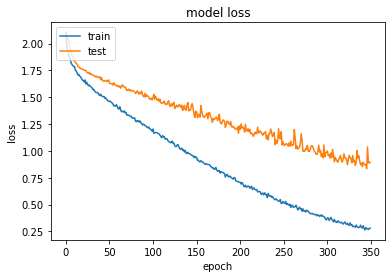

In [73]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [74]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [75]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 78.15%


In [80]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(df_female))):
    X, sample_rate = librosa.load(df_female.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(df_female.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 360/360 [00:19<00:00, 18.49it/s]


In [81]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

360/360 [==============================] - 3s 7ms/step


In [82]:
preds

array([[8.89371037e-01, 9.98296775e-04, 2.67891325e-02, ...,
        1.23201916e-03, 3.92267248e-03, 2.23361719e-02],
       [7.10252300e-03, 6.53563859e-03, 1.08013125e-02, ...,
        2.56032427e-03, 1.03728972e-01, 8.69000610e-03],
       [3.89834424e-03, 2.71061063e-02, 6.48356900e-02, ...,
        2.33421791e-02, 8.50952327e-01, 9.24142264e-03],
       ...,
       [8.65402818e-01, 3.90395639e-04, 6.95409477e-02, ...,
        1.08098262e-03, 7.42488075e-03, 2.21116878e-02],
       [5.30253947e-02, 6.17281068e-03, 1.07925631e-01, ...,
        2.82553514e-03, 6.44501820e-02, 1.23430602e-02],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]], dtype=float32)

In [83]:
preds1=preds.argmax(axis=1)

In [84]:
preds

array([[8.89371037e-01, 9.98296775e-04, 2.67891325e-02, ...,
        1.23201916e-03, 3.92267248e-03, 2.23361719e-02],
       [7.10252300e-03, 6.53563859e-03, 1.08013125e-02, ...,
        2.56032427e-03, 1.03728972e-01, 8.69000610e-03],
       [3.89834424e-03, 2.71061063e-02, 6.48356900e-02, ...,
        2.33421791e-02, 8.50952327e-01, 9.24142264e-03],
       ...,
       [8.65402818e-01, 3.90395639e-04, 6.95409477e-02, ...,
        1.08098262e-03, 7.42488075e-03, 2.21116878e-02],
       [5.30253947e-02, 6.17281068e-03, 1.07925631e-01, ...,
        2.82553514e-03, 6.44501820e-02, 1.23430602e-02],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]], dtype=float32)

In [85]:
flatten_preds = preds1.astype(int).flatten()

In [86]:
predictions = (lb.inverse_transform((flatten_preds)))

In [87]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,angry
1,fearful
2,sad
3,disgust
4,surprised
5,happy
6,calm
7,happy
8,neutral
9,calm


In [88]:
actual=test_valid_lb.argmax(axis=1)
actual_flatten = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((actual_flatten)))

In [89]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,angry
1,fearful
2,sad
3,disgust
4,surprised
5,happy
6,calm
7,happy
8,neutral
9,calm


In [90]:
finaldf = actualdf.join(preddf)

In [91]:
finaldf[20:40]

,actualvalues,predictedvalues
20,angry,angry
21,surprised,surprised
22,disgust,disgust
23,sad,sad
24,fearful,fearful
25,angry,angry
26,surprised,surprised
27,calm,calm
28,neutral,neutral
29,happy,happy


In [92]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
angry,48
calm,48
disgust,48
fearful,48
happy,48
neutral,24
sad,48
surprised,48


In [93]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
angry,96
calm,43
disgust,50
fearful,36
happy,42
neutral,15
sad,44
surprised,34


In [94]:
finaldf.to_csv('Predictions.csv', index=False)

In [95]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [96]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

83.33333333333334

In [97]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

84.1026176288826

In [98]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[46,  0,  1,  0,  1,  0,  0,  0],
       [ 3, 43,  2,  0,  0,  0,  0,  0],
       [ 1,  0, 47,  0,  0,  0,  0,  0],
       [13,  0,  0, 34,  0,  0,  1,  0],
       [ 6,  0,  0,  2, 39,  0,  0,  1],
       [ 8,  0,  0,  0,  1, 15,  0,  0],
       [ 4,  0,  0,  0,  1,  0, 43,  0],
       [15,  0,  0,  0,  0,  0,  0, 33]])

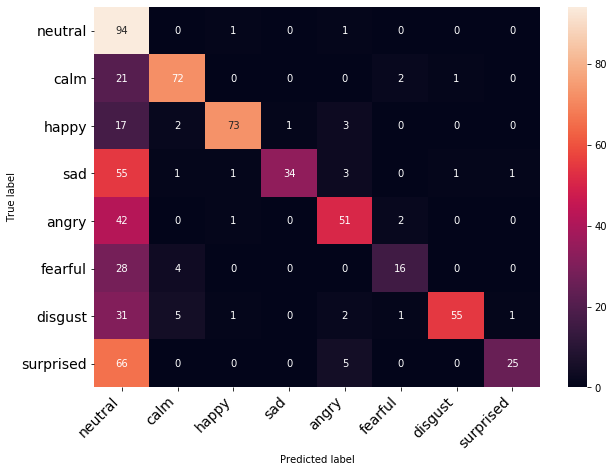

In [176]:
# Visualize Confusion Matrix 

class_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

print_confusion_matrix(cm, class_names)